In [1]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200 

In [2]:
df_rr = pd.read_csv('rr.csv')
df_twap_rp = pd.read_csv('twap-rp.csv')

In [3]:
df_rr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420 entries, 0 to 1419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   apy     1420 non-null   float64
 1   time    1420 non-null   object 
dtypes: float64(1), object(1)
memory usage: 22.3+ KB


In [4]:
df_twap_rp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7611 entries, 0 to 7610
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              7611 non-null   object 
 1   redemption_price  7611 non-null   float64
 2   twap              7611 non-null   float64
dtypes: float64(2), object(1)
memory usage: 178.5+ KB


Convert time column

In [5]:
df_twap_rp['time'] = pd.to_datetime(df_twap_rp['time'], infer_datetime_format=True, utc=True)
df_rr['time'] = pd.to_datetime(df_rr['time'], infer_datetime_format=True, utc=True)

Round time and drop duplicates

In [6]:
df_twap_rp['time_1m'] = df_twap_rp['time'].dt.round('1min') 
df_rr['time_1m'] = df_rr['time'].dt.round('1min') 

In [7]:
df_twap_rp = df_twap_rp.drop_duplicates(['time_1m']) 
df_rr = df_rr.drop_duplicates(['time_1m']) 

Set time index

In [8]:
df_twap_rp = df_twap_rp.set_index('time_1m')
df_rr = df_rr.set_index('time_1m')

Forward fill to allow a join between two dataframes

In [10]:
df_twap_rp = df_twap_rp.asfreq('1min', method='ffill')
df_rr = df_rr.asfreq('1min', method='ffill')

Join

In [11]:
df = pd.merge(df_rr['apy'], df_twap_rp[['redemption_price', 'twap']], left_index=True, right_index=True)

<AxesSubplot:xlabel='time_1m'>

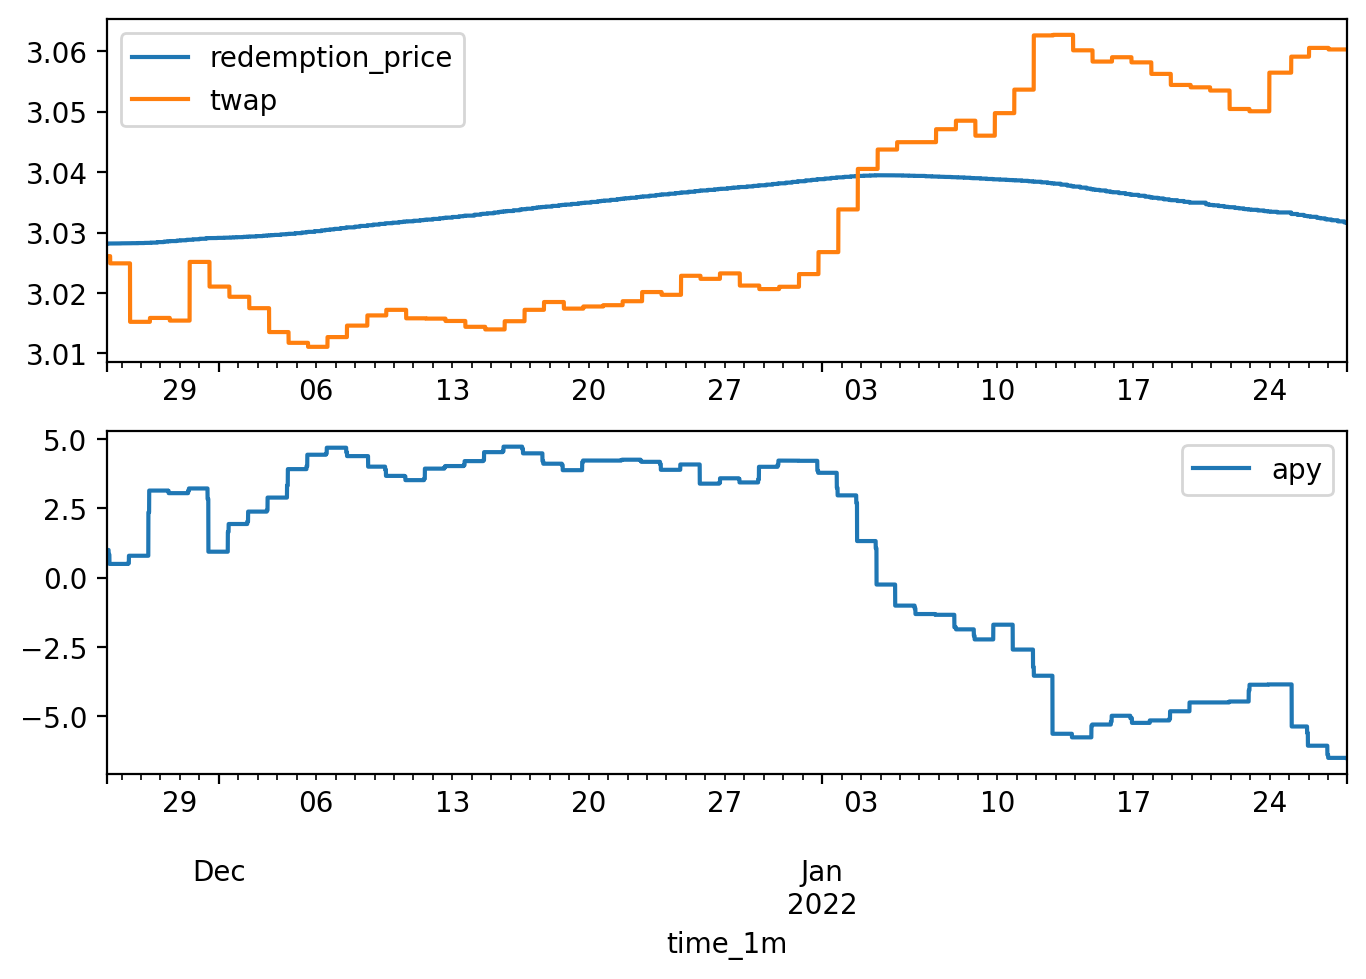

In [15]:
fig, ax = plt.subplots(2, 1)
df[['redemption_price', 'twap']].plot(ax=ax[0])
df[['apy']].plot(ax=ax[1])


In [18]:
df['error'] = df['redemption_price'] - df['twap']
df['redemption_price'].head(3)

time_1m
2021-11-25 06:00:00+00:00    3.028152
2021-11-25 06:01:00+00:00    3.028152
2021-11-25 06:02:00+00:00    3.028152
Freq: T, Name: redemption_price, dtype: float64

In [ ]:
def build(errors, kp, ki, time_period, start_idx=1):
    # rp starts at first twap value
    rps = [3.028152]
    rates = [0] 
    errors = [0] 
    error_integrals = [0] 
    for i, error in enumerate(errors):
        if i == 0:
            continue
        twap = rps[i] - error
        
        this_rp = rps[i-1] * (1+rates[i-1]) ** time_period

        old_integral = error_integrals[i-1]
        new_area = error * time_period

        new_integral = ALPHA ** time_period * old_integral + new_area

        error_integrals.append(new_integral)

        errors.append(error)
        rates.append(kp * error + ki * new_integral)
        rps.append(this_rp)
    return rps, rates, errors, error_integrals